In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import math

admissions = pd.read_csv("./data/ADMISSIONS.csv")
diagnoses = pd.read_csv("./data/DIAGNOSES_ICD.csv")
diagnoses_codes = pd.read_csv("./data/D_ICD_DIAGNOSES.csv")
patients = pd.read_csv("./data/PATIENTS.csv")
procedures = pd.read_csv("./data/PROCEDURES_ICD.csv")
procedures_codes = pd.read_csv("./data/D_ICD_PROCEDURES.csv")

# BME 590: Data Science and Health - Long Term Mortality Prediction

## Background

Patients usually go to a hospital to be for a single condition or injury. The caretakers will treat them, recommend further action if needed, and if all goes well, that patient will be discharged. What happens, however, if an unforseen complication arises after they are discharged from the hospital? Even worse, what if this condition is fatal? This is a less-than-rare problem that many healthcare systems, particularly those focused on population health or continuity of care, should be trying to solve. In this setting, population health is defined as the health outcome of the community of people that a healthcare system is providing for; continuity of care refers to the quality and level of care over a period of time.

In order to improve both population health and continuity of care then, treatments need to extend beyond the hospital interaction. If physicians and caretakers had a way to know long term mortality rate, then they could recommend further treatment - whether that be in-house care, follow up visits, or pallative care consults. With a stronger action plan, the long term mortality rate could be significantly lowered. Therefore, physicans need a method to predict long term mortality, up to one year in the future, in order to maintain continuity of care and increase overall population health. 

## Data

Data from the MIMIC-III database was used to create a machine learning model to predict whether or not a patient will die within one year of their initial admission to the hospital. The following tables were used:
- Admissions: information regarding a patient’s admission to the hospital
- Diagnoses: information regarding a patient's ICD diagnosis
- Patients: information regarding a patient's gender, age, and DOB/DOD
- Procedures: information regarding any ICD procedures performed on a patient

Since long term mortality was being investigated, subject who died during their hospital stay were removed from the Admissions table. Next, this subset was combined with the Patients table, which contained information about date of death. Finally, nonrelevant data was removed, and the following was kept:
- SUBJECT_ID: for future data joining
- HADM_ID: for future data joining
- MARITAL_STATUS: to see if having another person in the household had an effect
- INSURANCE: to see if access to healthcare had an effect
- DISCHARGE_LOCATION: to see if being sent home without further treatment had an effect

In [2]:
admissions = admissions[admissions.DEATHTIME.isnull()]
adm_pat_pre = pd.merge(left=admissions, right=patients[['SUBJECT_ID', 'DOD']], 
                               how='left', on='SUBJECT_ID')

adm_pat = adm_pat_pre[['SUBJECT_ID','HADM_ID','MARITAL_STATUS', 'INSURANCE', 
                       'DISCHARGE_LOCATION']]

adm_pat.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,INSURANCE,DISCHARGE_LOCATION
0,22,165315,MARRIED,Private,DISC-TRAN CANCER/CHLDRN H
1,23,152223,MARRIED,Medicare,HOME HEALTH CARE
2,23,124321,MARRIED,Medicare,HOME HEALTH CARE
3,24,161859,SINGLE,Private,HOME
4,25,129635,MARRIED,Private,HOME


Next, the Procedures table was looked at, since this contains all of the in-house treatment that a patient received at the hospital. Using this data, the effectiveness of a treatment plan was obtained, which can be used to see if the plan for a certain diagnosis was able to prevent death within one year. The total amount of procedures was also calculated, based on the highest sequence number for each treatment plan. This was then merged into the table generated earlier, and NaN values were removed.

In [3]:
proc = pd.merge(left=procedures, right=procedures_codes[['ICD9_CODE', 'SHORT_TITLE']], 
                               how='left', on='ICD9_CODE')
adm_pat_proc = pd.merge(left=adm_pat, right=proc[['HADM_ID','SEQ_NUM', 'ICD9_CODE', 'SHORT_TITLE']], 
                        how='left', on='HADM_ID')
adm_pat_proc.rename(columns={'SEQ_NUM': 'SEQ_NUM_PROC', 'ICD9_CODE': 'ICD9_CODE_PROC',
                            'SHORT_TITLE': 'PROC_NAME'}, inplace=True)
adm_pat_proc = adm_pat_proc.sort_values('SEQ_NUM_PROC', ascending=False).drop_duplicates(['HADM_ID'])
adm_pat_proc.dropna(how='any', inplace=True)
adm_pat_proc.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,INSURANCE,DISCHARGE_LOCATION,SEQ_NUM_PROC,ICD9_CODE_PROC,PROC_NAME
119399,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC
163373,57764,103584,SINGLE,Medicaid,HOME,40.0,3893.0,Venous cath NEC
123945,29467,194819,MARRIED,Private,REHAB/DISTINCT PART HOSP,40.0,9359.0,Immobiliz/wound attn NEC
179993,62795,173748,MARRIED,Medicaid,LONG TERM CARE HOSPITAL,40.0,3893.0,Venous cath NEC
138602,27755,155889,SINGLE,Medicaid,REHAB/DISTINCT PART HOSP,38.0,9672.0,Cont inv mec ven 96+ hrs


Finally, the Diagnoses table was looked at, to match the above procedures with a given treatment. Therefore, procedures can be mapped to diagnoses, to see what was and was not effective for a certain condition. Like before, this was merged into the table from earlier. To better match convention, the ICD-9 codes were truncated to be three digits.

In [4]:
diag = pd.merge(left=diagnoses, right=diagnoses_codes[['ICD9_CODE', 'SHORT_TITLE']], 
                               how='left', on='ICD9_CODE')
my_df = pd.merge(left=adm_pat_proc, right=diag[['HADM_ID','SEQ_NUM', 'ICD9_CODE', 'SHORT_TITLE']], 
                        how='left', on='HADM_ID')
my_df.rename(columns={'SEQ_NUM': 'SEQ_NUM_DIAG', 'ICD9_CODE': 'ICD9_CODE_DIAG',
                     'SHORT_TITLE': 'DIAG_NAME'}, inplace=True)

my_df['ICD9_CODE_DIAG'] = my_df['ICD9_CODE_DIAG'].astype(str)

for i in my_df['ICD9_CODE_DIAG'].index:
    peel = my_df.at[i, 'ICD9_CODE_DIAG']
    if peel[0].isalpha() and peel[0] != "n":
        my_df.at[i, 'ICD9_CODE_DIAG'] = peel[1:4]
    else:
        my_df.at[i, 'ICD9_CODE_DIAG'] = peel[0:3]

my_df['ICD9_CODE_DIAG'] = my_df['ICD9_CODE_DIAG'].replace('nan', np.nan)
my_df.dropna(how='any', inplace=True)
my_df['ICD9_CODE_DIAG'] = my_df['ICD9_CODE_DIAG'].astype(int)

my_df.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,INSURANCE,DISCHARGE_LOCATION,SEQ_NUM_PROC,ICD9_CODE_PROC,PROC_NAME,SEQ_NUM_DIAG,ICD9_CODE_DIAG,DIAG_NAME
0,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,1.0,533,Ac peptic ulc w perf-obs
1,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,2.0,995,"SIRS, NOS"
2,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,3.0,567,Peritonitis NOS
3,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,4.0,452,Portal vein thrombosis
4,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,5.0,567,Retroperiton abscess NEC


Now that all the relevant data was obtained in the right format, the *DOD* and *DISCHTIME* columns were compared to obtain an index of 1/0, referring to whether or not that patient died within a year. Any NaN values indicate that someone is still alive, so those were replaced with 0s.

In [5]:
adm_pat_pre[['DISCHTIME','DOD']] = adm_pat_pre[['DISCHTIME','DOD']].apply(pd.to_datetime)
my_df['lt_mortality'] = ((adm_pat_pre['DOD'] - adm_pat_pre['DISCHTIME']).dt.days <= 365).astype(int)
my_df = my_df.fillna(0)
my_df.tail()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,INSURANCE,DISCHARGE_LOCATION,SEQ_NUM_PROC,ICD9_CODE_PROC,PROC_NAME,SEQ_NUM_DIAG,ICD9_CODE_DIAG,DIAG_NAME,lt_mortality
450137,23837,199582,MARRIED,Private,REHAB/DISTINCT PART HOSP,1.0,3893.0,Venous cath NEC,3.0,599,Urin tract infection NOS,0.0
450138,23837,199582,MARRIED,Private,REHAB/DISTINCT PART HOSP,1.0,3893.0,Venous cath NEC,4.0,340,Multiple sclerosis,0.0
450139,23837,199582,MARRIED,Private,REHAB/DISTINCT PART HOSP,1.0,3893.0,Venous cath NEC,5.0,276,Hypopotassemia,0.0
450140,23837,199582,MARRIED,Private,REHAB/DISTINCT PART HOSP,1.0,3893.0,Venous cath NEC,6.0,995,Severe sepsis,0.0
450141,23837,199582,MARRIED,Private,REHAB/DISTINCT PART HOSP,1.0,3893.0,Venous cath NEC,7.0,285,Anemia NOS,0.0


## Data Analysis

### Marital Status
One thing that can have an effect on long term health is whether or not someone lives alone. Logically, having someone on hand can improve overall health care quality at home for long term conditions, and hasten treatment in case of an emergency. Therefore, physicians should consider this when thinking of treatment plans and long term mortality.

In [6]:
my_df['MARITAL_STATUS'].value_counts()

MARRIED              215746
SINGLE               117161
WIDOWED               66969
DIVORCED              31554
SEPARATED              5168
UNKNOWN (DEFAULT)      2575
LIFE PARTNER            195
Name: MARITAL_STATUS, dtype: int64

In [7]:
mar_1 = (my_df['MARITAL_STATUS'] == 'MARRIED').astype(int)
mar_2 = (my_df['MARITAL_STATUS'] == 'LIFE PARTNER').astype(int)
my_df['married'] = mar_1 + mar_2
my_df['married'].value_counts()

0    223427
1    215941
Name: married, dtype: int64

From this, we can see that 2415,941 patients were married, while conversely, 223,427 patients were single. This does, however, assume that anyone who is not married lives by themselves, which may not be true in the case of parents, roommates, children, etc.

### Insurance
The type of insurance that one has can often dictate their accessibility to healthcare. Those with private health insurance, or those who self pay, often have the resources to afford premier healthcare. As a result, certain procedures or treatment plans may not be made available to all, which can affect what physicians prescribe, and in turn, long term mortality.

In [8]:
my_df['INSURANCE'].value_counts()

Medicare      261447
Private       125710
Medicaid       39360
Government     10441
Self Pay        2410
Name: INSURANCE, dtype: int64

In [9]:
in_1 = (my_df['INSURANCE'] == 'Private').astype(int)
in_2 = (my_df['INSURANCE'] == 'Self Pay').astype(int)
my_df['own insurance'] = in_1 + in_2
my_df['own insurance'].value_counts()

0    311248
1    128120
Name: own insurance, dtype: int64

From this, we see that 128,120 patients access to private healthcare, while 311,248 patients relied on government aid to pay for their medical bills.

### Discharge Location
One factor mentioned earlier was continuity of care, which directly ties into discharge location. Someone who is sent home, will most likely have a diminished continuity of care compared to someone who is sent to a nursing facility, a rehab center, or another ward of the hospital for continued care. This is an important decision for a physician to make when determining a continued treatment plan, and should be considered when predicting long-term mortality.

In [10]:
my_df['DISCHARGE_LOCATION'].value_counts()

HOME HEALTH CARE             122205
HOME                          92782
SNF                           91411
REHAB/DISTINCT PART HOSP      71010
LONG TERM CARE HOSPITAL       39414
SHORT TERM HOSPITAL            5078
HOSPICE-HOME                   4659
DISC-TRAN CANCER/CHLDRN H      3834
DISCH-TRAN TO PSYCH HOSP       3247
LEFT AGAINST MEDICAL ADVI      2125
HOSPICE-MEDICAL FACILITY       1772
OTHER FACILITY                  704
ICF                             495
HOME WITH HOME IV PROVIDR       493
DISC-TRAN TO FEDERAL HC         125
SNF-MEDICAID ONLY CERTIF         14
Name: DISCHARGE_LOCATION, dtype: int64

In [11]:
no_home_1 = (my_df['DISCHARGE_LOCATION'] == 'HOME HEALTH CARE').astype(int)
no_home_2 = (my_df['DISCHARGE_LOCATION'] == 'HOME').astype(int)
my_df['sent home'] = no_home_1 + no_home_2
my_df['sent home'].value_counts()

0    224381
1    214987
Name: sent home, dtype: int64

From this, we see that 214,987 patients were sent directly home without a medical professional, and 224,381 patients were given a longer term treatment plan.

### Diagnoses
Diagnoses are often coded with ICD-9 convention, in the following manner:
- 001-139	Infectious And Parasitic Diseases
- 140-239	Neoplasms
- 240-279	Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
- 280-289	Diseases Of The Blood And Blood-Forming Organs
- 290-319	Mental Disorders
- 320-389	Diseases Of The Nervous System And Sense Organs
- 390-459	Diseases Of The Circulatory System
- 460-519	Diseases Of The Respiratory System
- 520-579	Diseases Of The Digestive System
- 580-629	Diseases Of The Genitourinary System
- 630-679	Complications Of Pregnancy, Childbirth, And The Puerperium
- 680-709	Diseases Of The Skin And Subcutaneous Tissue
- 710-739	Diseases Of The Musculoskeletal System And Connective Tissue
- 740-759	Congenital Anomalies
- 760-779	Certain Conditions Originating In The Perinatal Period
- 780-799	Symptoms, Signs, And Ill-Defined Conditions
- 800-999	Injury And Poisoning

These codes can be used to group and visualize the diagnoses within the dataset, in addition to the deaths related to that bucket.

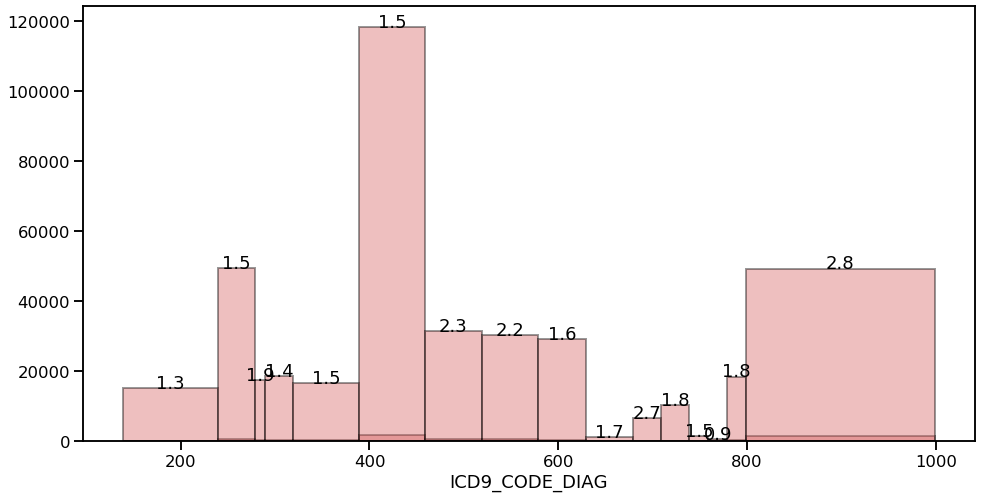

In [12]:
diag_bins = [139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739, 759, 779, 799, 999]

sns.set_context('talk')
f, ax = plt.subplots(figsize = (16,8))
sns.set_color_codes('muted')
sns.distplot(my_df.loc[my_df['lt_mortality'] == 1, 'ICD9_CODE_DIAG'], bins=diag_bins, 
             color='r', kde=False, axlabel="Diagnosis Code", hist_kws=dict(edgecolor="black", linewidth=2))
sns.set_color_codes('muted')
sns.distplot(my_df['ICD9_CODE_DIAG'], bins=diag_bins, kde=False, color='r', 
             hist_kws=dict(edgecolor="black", linewidth=2))

count = 0
death_array = [];
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height()
    value = '{:}'.format(p.get_height())
    if count <= 15:
        death_array.append(value)
    else:
        value = 100 * float(death_array[count - 16]) / float(value)
        value = round(value, 1)
        ax.text(_x, _y, value, ha="center")
    count += 1


From this, we see that the most common bin is 390-459 - Diseases Of The Circulatory System, followed by 240-279	- Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders and and 800-999 - Injury And Poisoning. If these are the most common, then physicians could prioritorize improving long term treatments in those areas, potentially improving overall population health. Most of the death percentages are below 2 percent, with 460-519 - Diseases Of The Respiratory System, 520-579 - Diseases Of The Digestive System, 680-709 - Diseases Of The Skin And Subcutaneous Tissue, and 800-999 - Injury And Poisoning being above 2 percent. Because Injury and Poisoning has the highest mortality rate, and is one of the most common categories, it can be an area of focus.

#### Holistic
Violin plots can be used to show the distribution of data. The widths of the two sides of the plot show the frequency of mortality - the wider the plot, the more amount of deaths there were/were not. On the vertical axis, this can be lined up to different diagnoses. On the horizontal axis, we can see if marital status, having private insurance, or being sent home had any drastic differences on the outcome.

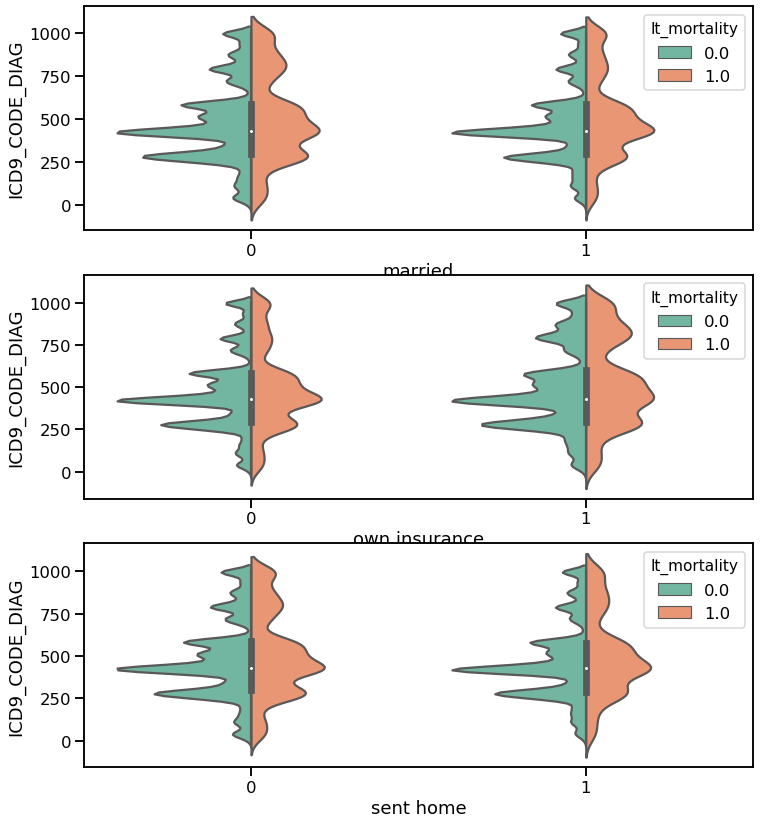

In [13]:
sns.set_context('talk')
f, ax = plt.subplots(3, 1, figsize = (12,14))
sns.violinplot(x="married", y="ICD9_CODE_DIAG", hue="lt_mortality",
                    data=my_df, palette="Set2", split="True", ax = ax[0])
sns.violinplot(x="own insurance", y="ICD9_CODE_DIAG", hue="lt_mortality",
                    data=my_df, palette="Set2", split="True", ax = ax[1])
sns.violinplot(x="sent home", y="ICD9_CODE_DIAG", hue="lt_mortality",
                    data=my_df, palette="Set2", split="True", ax = ax[2])

By comparing the areas of the violin plots, the effect that each of the three aformentioned binary factors had on long term mortality can be observed. Relatively speaking, it seems that the mortality rate is higher for patients who were not sent back to their home, own private insuranced, and were not married, in order of decreasing weight.

### Procedures
Procedures also follow a similar coding convention to diagnoses. What may be more interesting, however, is the amount of procedures that a patient undergoes, and seeing if there is a correlation between this and the long term mortality rate.

Mean without Death: 5.141268836501831
Mean with Death: 14.445309603262885


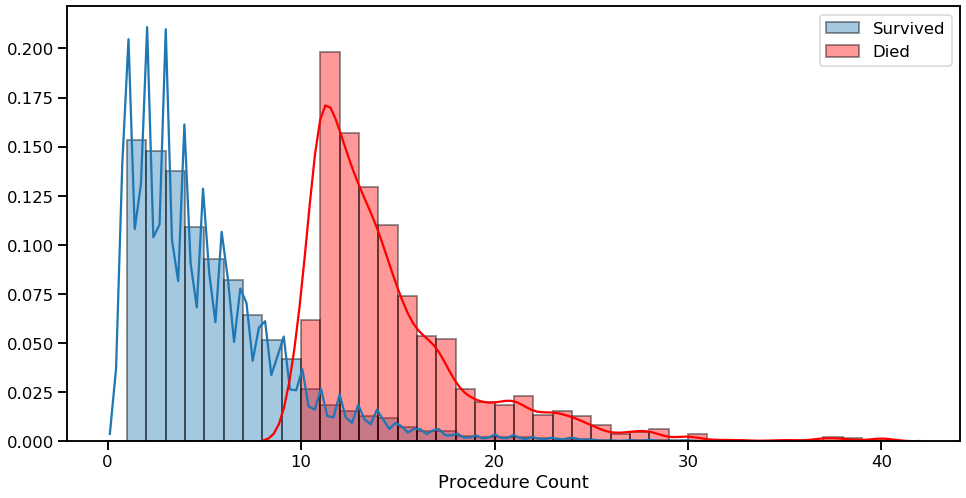

In [14]:
proc_bins = np.arange(40)

sns.set_context('talk')
f, ax = plt.subplots(figsize = (16,8))
sns.distplot(my_df.loc[my_df['lt_mortality'] == 0, 'SEQ_NUM_PROC'], bins=proc_bins,
             hist_kws=dict(edgecolor="black", linewidth=2), label="Survived")
print(f"Mean without Death: {my_df.loc[my_df['lt_mortality'] == 0, 'SEQ_NUM_PROC'].mean()}")
sns.distplot(my_df.loc[my_df['lt_mortality'] == 1, 'SEQ_NUM_PROC'], bins=proc_bins, color='red',
             axlabel = "Procedure Count", hist_kws=dict(edgecolor="black", linewidth=2),
             label="Died")
print(f"Mean with Death: {my_df.loc[my_df['lt_mortality'] == 1, 'SEQ_NUM_PROC'].mean()}")

ax.legend()

On average, a patient who lived longer than one year had an average of 5 procedures performed, while a patient who did not live past one year had an average of 14 procedures peformed. It is interesting to note that with a quick visual inspection, no one that died within a year had an less than 10 procedures performed on them.

#### Holistic
Just as we looked at the relationship between long term mortality, those three binary factors, and diagnoses, we will also do so with procedure. Since we used procedure count, and there are many less categories, a strip plot, or a categorical scatter plot, can be used to visualize this data. Therefore, we can view the amount of deaths per procedure count, and categorize it by marital status, access to private healthcare, and discharge location.

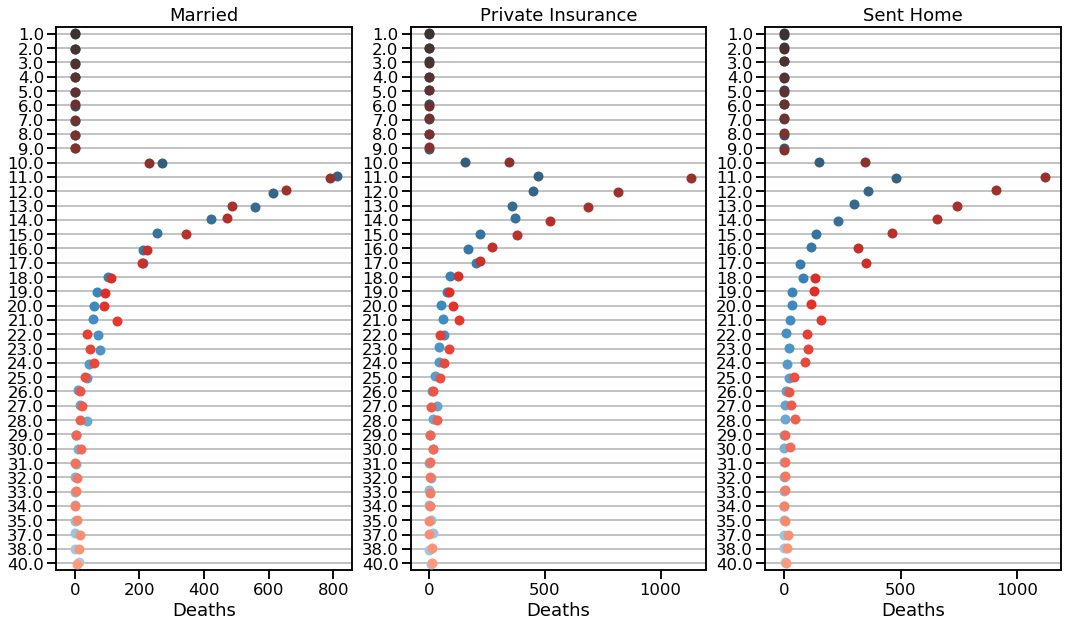

In [15]:
plot_cols = ['lt_mortality', 'SEQ_NUM_PROC', 'dead_married', 'dead_insurance', 'dead_home']
plot_df = pd.DataFrame(columns = plot_cols)
plot_df[['lt_mortality', 'SEQ_NUM_PROC']] = my_df[['lt_mortality', 'SEQ_NUM_PROC']]

plot_df['dead_married'] = my_df['lt_mortality'] + my_df['married']
plot_df['dead_insurance'] = my_df['lt_mortality'] + my_df['own insurance']
plot_df['dead_home']= my_df['lt_mortality'] + my_df['sent home']
plot_df['dead_married'] = (plot_df['dead_married'] == 2)
plot_df['dead_insurance'] = (plot_df['dead_insurance'] == 2)
plot_df['dead_home'] = (plot_df['dead_home'] == 2)

plot_df['dead_not_married'] = (plot_df['lt_mortality'] - plot_df['dead_married'])
plot_df['dead_not_insurance'] = (plot_df['lt_mortality'] - plot_df['dead_insurance'])
plot_df['dead_not_home'] = (plot_df['lt_mortality'] - plot_df['dead_home'])

final_plot_df = plot_df.groupby(['SEQ_NUM_PROC'], as_index=False).sum()

sns.set_context('talk')
f, ax = plt.subplots(1, 3, figsize = (18,10))

positive = ['dead_married', 'dead_insurance', 'dead_home']
negative = ['dead_not_married', 'dead_not_insurance', 'dead_not_home']

for i in range(3):
    sns.stripplot(y=final_plot_df['SEQ_NUM_PROC'], x=final_plot_df[positive[i]], size=10, orient="h",
          palette="Blues_d", linewidth=0, ax = ax[i])
    
for i in range(3):
    sns.stripplot(y=final_plot_df['SEQ_NUM_PROC'], x=final_plot_df[negative[i]], size=10, orient="h",
          palette="Reds_d", linewidth=0, ax = ax[i])

titles = ["Married", "Private Insurance", "Sent Home"]

for ax, title in zip(ax.flat, titles):

    ax.set(title=title, xlabel="Deaths", ylabel="")
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    

In each of these plots, blue represents the affirmation of the title, while red represents the refutation. In regards to density, these plots match the earlier histogram by showing a high amount of deaths between 10 and 15 procedures. Furthermore, the total amount of deaths in each of the categories confirm the previous weighting, of whether or not one is sent home having the strongest impact, and marital status having the lowest impact.

## Modeling

A design matrix was created to predict long term mortality. For each encounter, there will be information about the amount of procedures, types of diagnoses, marital status, insurance status, and whether or not that patient was sent home after their stay in the hospital. Additionally, there is one more column designating whether or not that patient died within one year of being discharged.

First, another column was created to organize the ICD9 codes into the buckets from above. This decreases the amount of input data, and combines related information together. We designate each category by the first number in that category. (We start at 0 to avoid conflict with the amount of procedures.)
- 001-139	Infectious And Parasitic Diseases
- 140-239	Neoplasms
- 240-279	Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
- 280-289	Diseases Of The Blood And Blood-Forming Organs
- 290-319	Mental Disorders
- 320-389	Diseases Of The Nervous System And Sense Organs
- 390-459	Diseases Of The Circulatory System
- 460-519	Diseases Of The Respiratory System
- 520-579	Diseases Of The Digestive System
- 580-629	Diseases Of The Genitourinary System
- 630-679	Complications Of Pregnancy, Childbirth, And The Puerperium
- 680-709	Diseases Of The Skin And Subcutaneous Tissue
- 710-739	Diseases Of The Musculoskeletal System And Connective Tissue
- 740-759	Congenital Anomalies
- 760-779	Certain Conditions Originating In The Perinatal Period
- 780-799	Symptoms, Signs, And Ill-Defined Conditions
- 800-999	Injury And Poisoning

In [36]:
for i in my_df['ICD9_CODE_DIAG'].index:
    code = my_df.at[i, 'ICD9_CODE_DIAG']
    if code >= 1 and code <= 139:
        my_df.at[i, 'ICD9_BUCKET'] = 0
    elif code >= 140 and code <= 239:
        my_df.at[i, 'ICD9_BUCKET'] = 140
    elif code >= 240 and code <= 279:
        my_df.at[i, 'ICD9_BUCKET'] = 240
    elif code >= 280 and code <= 289:
        my_df.at[i, 'ICD9_BUCKET'] = 280
    elif code >= 290 and code <= 319:
        my_df.at[i, 'ICD9_BUCKET'] = 290
    elif code >= 320 and code <= 389:
        my_df.at[i, 'ICD9_BUCKET'] = 320
    elif code >= 390 and code <= 459:
        my_df.at[i, 'ICD9_BUCKET'] = 390
    elif code >= 460 and code <= 519:
        my_df.at[i, 'ICD9_BUCKET'] = 460
    elif code >= 520 and code <= 579:
        my_df.at[i, 'ICD9_BUCKET'] = 520
    elif code >= 580 and code <= 629:
        my_df.at[i, 'ICD9_BUCKET'] = 580
    elif code >= 630 and code <= 679:
        my_df.at[i, 'ICD9_BUCKET'] = 630
    elif code >= 680 and code <= 709:
        my_df.at[i, 'ICD9_BUCKET'] = 680
    elif code >= 710 and code <= 739:
        my_df.at[i, 'ICD9_BUCKET'] = 710
    elif code >= 740 and code <= 759:
        my_df.at[i, 'ICD9_BUCKET'] = 740
    elif code >= 760 and code <= 779:
        my_df.at[i, 'ICD9_BUCKET'] = 760
    elif code >= 780 and code <= 799:
        my_df.at[i, 'ICD9_BUCKET'] = 780
    elif code >= 800 and code <= 999:
        my_df.at[i, 'ICD9_BUCKET'] = 800

my_df.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,INSURANCE,DISCHARGE_LOCATION,SEQ_NUM_PROC,ICD9_CODE_PROC,PROC_NAME,SEQ_NUM_DIAG,ICD9_CODE_DIAG,DIAG_NAME,lt_mortality,married,own insurance,sent home,ICD9_BUCKET
0,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,1.0,533,Ac peptic ulc w perf-obs,0.0,1,1,1,520.0
1,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,2.0,995,"SIRS, NOS",0.0,1,1,1,800.0
2,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,3.0,567,Peritonitis NOS,0.0,1,1,1,520.0
3,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,4.0,452,Portal vein thrombosis,0.0,1,1,1,390.0
4,24810,143994,MARRIED,Private,HOME HEALTH CARE,40.0,9729.0,Non-op replacement NEC,5.0,567,Retroperiton abscess NEC,0.0,1,1,1,520.0


Next, the data was transformed from long format to wide format. This puts it a matrix form where each procedure count and ICD9 category can be represented by its own column.

In [37]:
proc_wide = my_df.groupby(['HADM_ID', 'SEQ_NUM_PROC']).size().unstack()
proc_wide = proc_wide.reset_index()
proc_wide.head()

SEQ_NUM_PROC,HADM_ID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,30.0,31.0,32.0,33.0,34.0,35.0,37.0,38.0,40.0
0,100003,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100006,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100007,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100009,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100010,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
diag_wide = my_df.groupby(['HADM_ID', 'ICD9_BUCKET']).size().unstack()
diag_wide = diag_wide.reset_index()
diag_wide.head()

ICD9_BUCKET,HADM_ID,0.0,140.0,240.0,280.0,290.0,320.0,390.0,460.0,520.0,580.0,630.0,680.0,710.0,740.0,760.0,780.0,800.0
0,100003,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,100006,1.0,2.0,1.0,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,100007,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100009,NaN,2.0,3.0,1.0,NaN,NaN,9.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,100010,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, each of the category columns was binarized, since the machine learing model needs to take in 0s and 1s. In order to do this, all NaNs were replaced with 0s, and any number greater than 1 was reduced to 1. The reduction is allowed since for the diagnoses codes, all that matters is that a category was present, instead of the amount. For the procedure count, the total amount of procedures is listed in each category per encounter; for example, a patient that had 7 procedures done did not have 1 procedure done 7 times, 2 procedures done 7 times, etc. - said patient only had each specific number done once.

In [39]:
proc_wide = proc_wide.fillna(0)
for column in proc_wide:
    if column != "HADM_ID":
        proc_wide[column] = proc_wide[column].mask(proc_wide[column] > 1, 1)

proc_wide.head()

SEQ_NUM_PROC,HADM_ID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,29.0,30.0,31.0,32.0,33.0,34.0,35.0,37.0,38.0,40.0
0,100003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100009,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100010,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
diag_wide = diag_wide.fillna(0)
for column in diag_wide:
    if column != "HADM_ID":
        diag_wide[column] = diag_wide[column].mask(diag_wide[column] > 1, 1)
        
diag_wide.head()

ICD9_BUCKET,HADM_ID,0.0,140.0,240.0,280.0,290.0,320.0,390.0,460.0,520.0,580.0,630.0,680.0,710.0,740.0,760.0,780.0,800.0
0,100003,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100006,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100007,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100009,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100010,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, all of the data was merged together to create the final design matrix, and the *HADM_ID* was changed to all 1s to provide the intercept column, as identification data is no longer needed.

In [52]:
design_matrix = pd.merge(left=proc_wide, right=diag_wide, how='left', on='HADM_ID')
design_matrix = pd.merge(left=design_matrix, right=my_df[['HADM_ID', 'married', 'own insurance','sent home', 
                                                'lt_mortality']], how='left', on='HADM_ID')
design_matrix['HADM_ID'] = 1
design_matrix = design_matrix.rename(columns={'HADM_ID' : 'Intercept'})
design_matrix.head()

,Intercept,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,680.0,710.0,740.0,760.0,780.0,800.0,married,own insurance,sent home,lt_mortality
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0.0
2,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0.0
3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0.0


The model was then fit using logistic regression, using a training size of 80 percent, and a test size of 20 percent. The training size was chosen out of convention. Because scikit uses SGD, and selects random batches to train on, no learning rate needs to be set. The regularization constant, C, was chosen through iterative testing to see what gave the most accuracy, and a value of 0.2 was landed on. Finally, the tolerance was chosen for a balance of computational power and accuracy - making the tolerance smaller than 0.0001 did not change the accuarcy at all, but it increased the amount of computations, making it unsavory.

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(design_matrix_val[:, :-1], design_matrix_val[:, -1], 
                                                    test_size=.2)
lr = LogisticRegression(penalty='l2', C=0.2, solver='lbfgs', max_iter=1000, tol = 1e-4)
lr.fit(X_train, y_train)
predictions = lr.predict_proba(X_test)
log_score = roc_auc_score(y_test, predictions[:, 1])

print(f"Logistic Regression Accuracy: {log_score}")

Logistic Regression Accuracy: 0.9502735953065993


From this, we can see that the model was 95 percent accurate, so it can strongly predict long term mortality based on the inputs that it was given.

## Suggestions

The model performed remarkably well. When patients are about to be discharged from the hospital then, physicans can use this model to see whether or not they will die within a year. If the model predicts that they will, a longer hospital stay, or a different long term treatment plan can be suggested. If the model predicts that they will not, then the physican can say with 95% confidence that their current plan is a good one. If the model were to be improved, additional biometric data can be added - sex, age, heart rate, existing conditions, etc. can all be incorporated into the model. This will give the model more data to work with, and more weights and parameters to tune, allowing it to potentially increase it accuracy.

## Conclusions

We stated that physicans needed a machine learning model that allowed them predict long term mortality, in order to increase population health, and maintain continuity of care. This model aids them in doing so. If they have a current discharge plan, and know certain socioeconomic and health factors of a patient, then they can put that information into this model, and see what the prediction on mortality is. Using that information, they can make a better judgement of a treatment plan. This can increase the lifespan of a patient once he is discharged, improving overall population health when used by many. In regards to continuity of care, if a patient is predicted to die, the he/she can be sent to a rehab center, a nursing center, a long-term care hospital ward, etc. in order to maintain continuity of care. All in all, this model performed with a high accuracy, and can be a useful tool for physicans.

### Grant Mak (gem18)